In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime

In [2]:
#Read the csv file
df = pd.read_csv('/kaggle/input/bitcoin-price-dataset/bitcoin_2017_to_2023.csv')
print(df.head()) #7 columns, including the Date.

             timestamp      open      high       low     close    volume  \
0  2023-08-01 13:19:00  28902.48  28902.49  28902.48  28902.49   4.68658   
1  2023-08-01 13:18:00  28902.48  28902.49  28902.48  28902.49   4.77589   
2  2023-08-01 13:17:00  28908.52  28908.53  28902.48  28902.49  11.52263   
3  2023-08-01 13:16:00  28907.41  28912.74  28907.41  28908.53  15.89610   
4  2023-08-01 13:15:00  28896.00  28907.42  28893.03  28907.41  37.74657   

   quote_asset_volume  number_of_trades  taker_buy_base_asset_volume  \
0        1.354538e+05               258                      0.89391   
1        1.380351e+05               317                      2.24546   
2        3.330532e+05               451                      2.70873   
3        4.595556e+05               483                     10.22981   
4        1.090761e+06               686                     16.50452   

   taker_buy_quote_asset_volume  
0                  25836.224836  
1                  64899.385195  
2       

In [3]:
df.isnull().sum()

timestamp                       0
open                            0
high                            0
low                             0
close                           0
volume                          0
quote_asset_volume              0
number_of_trades                0
taker_buy_base_asset_volume     0
taker_buy_quote_asset_volume    0
dtype: int64

In [4]:
# Convert the 'date' column to datetime if it's not already
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Resample to 1-hour intervals
df = df.resample('1H', on='timestamp').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'mean',
    'quote_asset_volume': 'mean',
    'number_of_trades': 'mean',
    'taker_buy_base_asset_volume': 'mean',
    'taker_buy_quote_asset_volume': 'mean'
})

df.reset_index(drop=False, inplace=True)
print(df.head())

            timestamp     open     high      low    close    volume  \
0 2017-08-17 04:00:00  4261.48  4313.62  4261.32  4308.83  0.786350   
1 2017-08-17 05:00:00  4308.83  4328.69  4291.37  4315.32  0.387249   
2 2017-08-17 06:00:00  4315.32  4345.45  4309.37  4324.35  0.120495   
3 2017-08-17 07:00:00  4324.35  4349.99  4287.41  4349.99  0.074054   
4 2017-08-17 08:00:00  4333.32  4377.85  4333.32  4360.69  0.016213   

   quote_asset_volume  number_of_trades  taker_buy_base_asset_volume  \
0         3372.768973          2.850000                     0.586008   
1         1671.747059          1.700000                     0.357468   
2          521.371878          0.600000                     0.080048   
3          320.684305          0.416667                     0.043372   
4           70.658393          0.466667                     0.013578   

   taker_buy_quote_asset_volume  
0                   2515.874632  
1                   1543.471329  
2                    346.588620  
3   

In [5]:
# Create a mask to filter the date range
mask = (df['timestamp'] >= '2018-01-01') & (df['timestamp'] <= '2022-01-31')

# Apply the mask to get the filtered DataFrame
in_sample_df = df[mask].sort_values(by='timestamp')

print(in_sample_df.head())
print(in_sample_df.tail())

               timestamp      open      high       low     close    volume  \
3284 2018-01-01 00:00:00  13715.65  13715.65  13400.01  13529.01  7.389270   
3285 2018-01-01 01:00:00  13528.99  13595.89  13155.38  13203.06  6.394950   
3286 2018-01-01 02:00:00  13203.00  13418.43  13200.00  13330.18  7.151076   
3287 2018-01-01 03:00:00  13330.26  13611.27  13290.00  13410.03  7.001451   
3288 2018-01-01 04:00:00  13434.98  13623.29  13322.15  13601.01  5.680122   

      quote_asset_volume  number_of_trades  taker_buy_base_asset_volume  \
3284        99898.497267         87.133333                     3.808699   
3285        85908.692586         75.566667                     3.014007   
3286        95169.866975         81.450000                     3.203966   
3287        94290.807622         79.816667                     2.298640   
3288        76467.449936         76.050000                     2.882627   

      taker_buy_quote_asset_volume  
3284                  51509.018429  
3285  

In [6]:
# Out-of-Sample 1: Feb 1, 2022, to Dec 31, 2022
out_of_sample_1_mask = (df['timestamp'] >= '2022-02-01') & (df['timestamp'] <= '2022-12-31')
out_of_sample_1_df = df[out_of_sample_1_mask].sort_values(by='timestamp')

print(out_of_sample_1_df.head())
print(out_of_sample_1_df.tail())

                timestamp      open      high       low     close     volume  \
39092 2022-02-01 00:00:00  38466.90  38627.35  38276.43  38342.36  17.640433   
39093 2022-02-01 01:00:00  38342.37  38407.00  38175.86  38238.19  12.964385   
39094 2022-02-01 02:00:00  38238.18  38506.18  38196.61  38480.90  12.780641   
39095 2022-02-01 03:00:00  38480.90  38649.90  38384.99  38596.82  15.774275   
39096 2022-02-01 04:00:00  38596.82  38644.57  38470.37  38556.82  12.648797   

       quote_asset_volume  number_of_trades  taker_buy_base_asset_volume  \
39092       677485.637483        494.300000                     8.453010   
39093       496395.681070        410.433333                     6.288635   
39094       490259.238603        438.483333                     7.414131   
39095       607766.285153        532.133333                     7.275782   
39096       487697.254547        428.500000                     5.962861   

       taker_buy_quote_asset_volume  
39092                 32

In [7]:
# Out-of-Sample 2: Jan 1, 2023, to Dec 31, 2023
out_of_sample_2_mask = (df['timestamp'] >= '2023-01-01') & (df['timestamp'] <= '2023-12-31')
out_of_sample_2_df = df[out_of_sample_2_mask].sort_values(by='timestamp')
print(out_of_sample_2_df.head())
print(out_of_sample_2_df.tail())

                timestamp      open      high       low     close     volume  \
47108 2023-01-01 00:00:00  16541.77  16545.70  16508.39  16529.67  72.747262   
47109 2023-01-01 01:00:00  16529.59  16556.80  16525.78  16551.47  59.834445   
47110 2023-01-01 02:00:00  16551.47  16559.77  16538.14  16548.19  55.314006   
47111 2023-01-01 03:00:00  16548.19  16548.19  16518.21  16533.04  70.701342   
47112 2023-01-01 04:00:00  16533.04  16535.97  16511.92  16521.85  71.416818   

       quote_asset_volume  number_of_trades  taker_buy_base_asset_volume  \
47108        1.202438e+06       2497.566667                    36.332462   
47109        9.896126e+05       2109.266667                    28.837484   
47110        9.153242e+05       1923.300000                    26.852050   
47111        1.168709e+06       2295.400000                    34.934881   
47112        1.180044e+06       2158.916667                    36.473363   

       taker_buy_quote_asset_volume  
47108                 60

In [8]:
from sklearn.model_selection import train_test_split
train_size = 0.9
test_size = 0.1
train_df, test_df = train_test_split(in_sample_df, test_size=test_size, shuffle=False)

In [9]:
train_df

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
3284,2018-01-01 00:00:00,13715.65,13715.65,13400.01,13529.01,7.389270,9.989850e+04,87.133333,3.808699,51509.018429
3285,2018-01-01 01:00:00,13528.99,13595.89,13155.38,13203.06,6.394950,8.590869e+04,75.566667,3.014007,40507.491549
3286,2018-01-01 02:00:00,13203.00,13418.43,13200.00,13330.18,7.151076,9.516987e+04,81.450000,3.203966,42641.744294
3287,2018-01-01 03:00:00,13330.26,13611.27,13290.00,13410.03,7.001451,9.429081e+04,79.816667,2.298640,30967.354291
3288,2018-01-01 04:00:00,13434.98,13623.29,13322.15,13601.01,5.680122,7.646745e+04,76.050000,2.882627,38800.965337
...,...,...,...,...,...,...,...,...,...,...
35485,2021-09-03 17:00:00,50483.85,50595.00,50312.00,50396.59,33.484045,1.690766e+06,1234.866667,16.354628,825809.192399
35486,2021-09-03 18:00:00,50396.59,50567.26,50210.67,50458.79,28.870331,1.454150e+06,685.516667,15.963271,804133.111251
35487,2021-09-03 19:00:00,50458.79,50541.66,50264.85,50528.49,15.319158,7.721458e+05,481.166667,7.459997,375998.060542
35488,2021-09-03 20:00:00,50528.50,50534.32,50028.00,50132.74,21.850547,1.097186e+06,822.533333,9.890670,496607.393340


In [10]:
test_df

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
35490,2021-09-03 22:00:00,50239.89,50248.22,49600.00,49693.78,34.875822,1.737982e+06,969.616667,14.301818,712713.115633
35491,2021-09-03 23:00:00,49693.78,50041.58,49570.00,49999.14,31.104002,1.548178e+06,1184.550000,14.029110,698383.217007
35492,2021-09-04 00:00:00,49998.00,50142.85,49683.85,49918.54,34.331794,1.714565e+06,1192.666667,16.280003,813031.510436
35493,2021-09-04 01:00:00,49918.54,49918.54,49575.83,49688.72,26.527110,1.319686e+06,821.616667,12.056755,599829.989944
35494,2021-09-04 02:00:00,49688.73,50127.24,49600.00,50126.29,25.511012,1.271707e+06,850.216667,12.937229,644911.722152
...,...,...,...,...,...,...,...,...,...,...
39064,2022-01-30 20:00:00,37512.37,37740.00,37351.63,37684.45,17.298709,6.498965e+05,564.183333,8.373942,314633.355183
39065,2022-01-30 21:00:00,37684.45,37762.60,37492.25,37729.00,14.567675,5.483442e+05,440.650000,6.455671,242949.293761
39066,2022-01-30 22:00:00,37729.00,37855.54,37625.41,37785.78,12.244309,4.619958e+05,449.300000,7.081605,267228.269010
39067,2022-01-30 23:00:00,37785.78,38230.00,37778.46,37881.76,28.813530,1.096494e+06,689.316667,15.923534,606143.508443


In [11]:
#Variables for training
cols = list(df)[1:]
#Date and volume columns are not used in training. 
df_for_training = train_df[cols].astype(float)
df_for_training

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
3284,13715.65,13715.65,13400.01,13529.01,7.389270,9.989850e+04,87.133333,3.808699,51509.018429
3285,13528.99,13595.89,13155.38,13203.06,6.394950,8.590869e+04,75.566667,3.014007,40507.491549
3286,13203.00,13418.43,13200.00,13330.18,7.151076,9.516987e+04,81.450000,3.203966,42641.744294
3287,13330.26,13611.27,13290.00,13410.03,7.001451,9.429081e+04,79.816667,2.298640,30967.354291
3288,13434.98,13623.29,13322.15,13601.01,5.680122,7.646745e+04,76.050000,2.882627,38800.965337
...,...,...,...,...,...,...,...,...,...
35485,50483.85,50595.00,50312.00,50396.59,33.484045,1.690766e+06,1234.866667,16.354628,825809.192399
35486,50396.59,50567.26,50210.67,50458.79,28.870331,1.454150e+06,685.516667,15.963271,804133.111251
35487,50458.79,50541.66,50264.85,50528.49,15.319158,7.721458e+05,481.166667,7.459997,375998.060542
35488,50528.50,50534.32,50028.00,50132.74,21.850547,1.097186e+06,822.533333,9.890670,496607.393340


In [12]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)
df_for_training_scaled

array([[-0.10112397, -0.10678406, -0.11643668, ..., -0.72641196,
        -0.84773697, -0.52217327],
       [-0.11375395, -0.11483113, -0.13311353, ..., -0.74511003,
        -0.89128855, -0.54133942],
       [-0.13581143, -0.12675525, -0.13007171, ..., -0.73559934,
        -0.88087822, -0.53762126],
       ...,
       [ 2.38502885,  2.36767679,  2.39670437, ..., -0.08943847,
        -0.64763453,  0.04313063],
       [ 2.38974564,  2.36718359,  2.38055789, ...,  0.46239686,
        -0.51442612,  0.25324843],
       [ 2.36287867,  2.34805904,  2.38084899, ...,  0.93265045,
        -0.54746405,  0.19966439]])

In [13]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 9. We will make timesteps = 24 (past 24 hours data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of hours we want to look into the future based on the past days.
n_past = 24  # Number of past hours we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, :])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 3])

trainX, trainY = np.array(trainX), np.array(trainY)

# Find indices of rows with NaN values in either trainX or trainY
nan_indices_x = np.isnan(trainX).any(axis=(1, 2))
nan_indices_y = np.isnan(trainY).flatten()

# Find the union of indices to drop
nan_indices_combined = np.logical_or(nan_indices_x, nan_indices_y)

# Remove rows with NaN values from both trainX and trainY
trainX = trainX[~nan_indices_combined]
trainY = trainY[~nan_indices_combined]

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
trainY

trainX shape == (31463, 24, 9).
trainY shape == (31463, 1).


array([[-0.09886724],
       [-0.10901649],
       [-0.11429375],
       ...,
       [ 2.38945937],
       [ 2.36268406],
       [ 2.36993352]])

In [14]:
np.isnan(trainX).sum()

0

In [15]:
# Install TensorFlow GPU version
# !pip install tensorflow-gpu

In [16]:
# import tensorflow as tf

# # Check if GPU is available
# if tf.test.gpu_device_name():
#     print('GPU device found:', tf.test.gpu_device_name())
# else:
#     print("No GPU found. Make sure you have configured Kaggle to use GPU in the notebook settings.")

In [17]:
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.75
                                            , min_lr=0.00001)

In [18]:
lstm_units = 12
dense_units = 6
window_size = 24
n_features = 9  #  9 features in our input data
output_size = 1

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=10,
                              restore_best_weights=True)
#rnn
model = Sequential([
    LSTM(units=lstm_units,
         dropout=.1,
         recurrent_dropout=.1,
         input_shape=(window_size, n_features), name='LSTM',
         return_sequences=False),
    Dense(dense_units, name='FC'),
    Dense(output_size, name='Output')
])

model.compile(loss='mse', optimizer='RMSProp')
model.summary()

# Reshape trainX to match the expected input shape of the LSTM layer
trainX_reshaped = trainX.reshape((trainX.shape[0], window_size, n_features))

history = model.fit(trainX_reshaped,
                 trainY,
                 epochs=50,
                 batch_size=20,
                 shuffle=False,
                 validation_split=0.1,
                 callbacks=early_stopping,
                 verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 12)                1056      
                                                                 
 FC (Dense)                  (None, 6)                 78        
                                                                 
 Output (Dense)              (None, 1)                 7         
                                                                 
Total params: 1141 (4.46 KB)
Trainable params: 1141 (4.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
1416/1416 [==============================] - 26s 17ms/step - loss: 0.0045 - val_loss: 0.8619
Epoch 2/50
1416/1416 [==============================] - 23s 16ms/step - loss: 0.0046 - val_loss: 0.7043
Epoch 3/50
1416/1416 [==============================] - 23s 16ms/step - loss: 0.

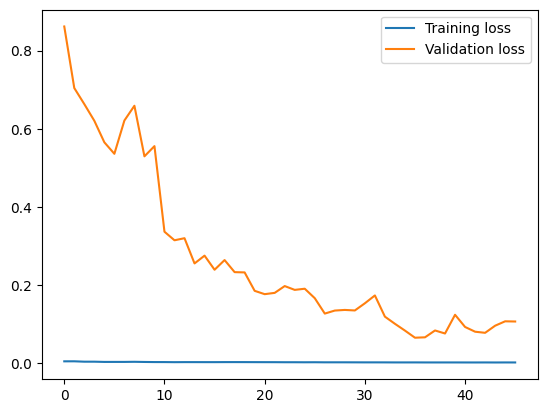

In [19]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def testing(test_df):
    df_for_testing = test_df[cols].astype(float)
    scaler = StandardScaler()
    scaler = scaler.fit(df_for_testing)
    df_for_testing_scaled = scaler.transform(df_for_testing)
    
    # Empty lists to be populated using formatted testing data
    testX = []
    testY = []
    testY_open=[]
    testY_high=[]
    testY_low=[]
    # Reformat input data into a shape: (n_samples x timesteps x n_features)
    for i in range(n_past, len(df_for_testing_scaled) - n_future + 1):
        testX.append(df_for_testing_scaled[i - n_past:i, :])
        testY.append(df_for_testing_scaled[i + n_future - 1:i + n_future, 3])
        testY_open.append(df_for_testing_scaled[i + n_future - 1:i + n_future, 0])
        testY_high.append(df_for_testing_scaled[i + n_future - 1:i + n_future, 1])
        testY_low.append(df_for_testing_scaled[i + n_future - 1:i + n_future, 2])
    testX, testY = np.array(testX), np.array(testY)

    # Find indices of rows with NaN values in either trainX or trainY
    nan_indices_x = np.isnan(testX).any(axis=(1, 2))
    nan_indices_y = np.isnan(testY).flatten()

    # Find the union of indices to drop
    nan_indices_combined = np.logical_or(nan_indices_x, nan_indices_y)

    # Remove rows with NaN values from both trainX and trainY
    testX = testX[~nan_indices_combined]
    testY = testY[~nan_indices_combined]
    print('testX shape == {}.'.format(testX.shape))
    print('testY shape == {}.'.format(testY.shape))

    predictions = model.predict(testX)
    # Print or use the predictions as needed
    print('Predictions shape:', predictions.shape)
    
    #Perform inverse transformation to rescale back to original range
    #Since we used 5 variables for transform, the inverse expects same dimensions
    #Therefore, let us copy our values 9 times and discard them after inverse transform
    prediction_copies = np.repeat(predictions, df_for_testing.shape[1], axis=-1)
    predictions_original_scale = scaler.inverse_transform(prediction_copies)[:,0]
    
    testY_copies = np.repeat(testY, df_for_testing.shape[1], axis=-1)
    testY_open_copies = np.repeat(testY_open, df_for_testing.shape[1], axis=-1)
    testY_high_copies = np.repeat(testY_high, df_for_testing.shape[1], axis=-1)
    testY_low_copies = np.repeat(testY_low, df_for_testing.shape[1], axis=-1)
    testY_original_scale = scaler.inverse_transform(testY_copies)[:,0]
    testY_open_original_scale = scaler.inverse_transform(testY_open_copies)[:,0]
    testY_high_original_scale = scaler.inverse_transform(testY_high_copies)[:,0]
    testY_low_original_scale = scaler.inverse_transform(testY_low_copies)[:,0]
    
    # Plot the actual values vs. predicted values
    plt.figure(figsize=(40, 15))
    plt.plot(testY_original_scale, label='Actual Values', linestyle='-', marker='o')
    plt.plot(predictions_original_scale, label='Predicted Values', linestyle='-', marker='o')
    plt.title('Actual vs. Predicted Values')
    plt.xlabel('Data Points')
    plt.ylabel('Values')
    plt.legend()
    plt.show()
    
    # Make predictions on training data (BACKTESTING)
    train_predictions = model.predict(trainX)
    train_predictions_original_scale = scaler.inverse_transform(np.repeat(train_predictions, df_for_training.shape[1], axis=-1))[:,0]

    trainY_copies = np.repeat(trainY, df_for_training.shape[1], axis=-1)
    trainY_original_scale = scaler.inverse_transform(trainY_copies)[:,0]

    # Calculate RMSE for training data
    train_rmse = np.sqrt(mean_squared_error(trainY_original_scale , train_predictions_original_scale))

    print('BACKTESTING RMSE: {:.2f}'.format(train_rmse))


    test_rmse = np.sqrt(mean_squared_error(testY_original_scale, predictions_original_scale))
    print('Testing RMSE: {:.2f}'.format(test_rmse))
    
    # buy:1, sell: -1, hold: 0
    result_array = np.where(predictions_original_scale[1:] > testY_original_scale[:-1], 1, -1)
    result_array = np.where((result_array == -1) & (np.roll(result_array, 1) == -1), 0, result_array)
    result_array = np.where((result_array == 1) & (np.roll(result_array, 1) == 1), 0, result_array)
    
    # Initialize variables for tracking trading strategy performance
    initial_capital = 100000
    current_capital = 100000
    No_of_trades = 0
    No_of_profits = 0
    No_of_loss = 0
    max_profit = 0
    max_loss = 0
    capital_at_max_loss = 0
    gross_profit = 0
    gross_loss = 0
    current_stocks = 0
    prev_capital = 0
    buy = []
    sell = []
    No_of_Holdings = 0
    max_holding = 0
    index_start_hold = 0
    lowest_during_hold = 100000000
    lowest_per_trade = []
    peak_during_hold = 0
    peak_per_trade = []
    
    for i in range(len(result_array)):
        if(current_stocks==0 and result_array[i] == 1):
            stock_bought = current_capital/ min(testY_original_scale[i],testY_open_original_scale[i])
            current_stocks = stock_bought
            buy.append(current_capital)
            prev_capital = current_capital
            current_capital= 0

            lowest_during_hold = 100000000
            peak_during_hold = 0
            index_start_hold = i
            lowest_during_hold = min(lowest_during_hold,testY_low_original_scale[i])
            peak_during_hold = max(peak_during_hold,testY_high_original_scale[i])

        elif(current_stocks>0 and result_array[i] == -1):
            No_of_trades = No_of_trades+1
            current_capital = current_stocks * max(testY_open_original_scale[i],testY_original_scale[i])
            sell.append(current_capital)

            if (current_capital > prev_capital):
                gross_profit += (current_capital - prev_capital)
                max_profit = max(max_profit,(current_capital - prev_capital))
                No_of_profits = No_of_profits +1
            else:
                gross_loss += (current_capital - prev_capital)
                max_loss = min(max_loss,(current_capital - prev_capital))
                if(max_loss == (current_capital - prev_capital)):
                    capital_at_max_loss = prev_capital
                No_of_loss = No_of_loss + 1

            current_stocks = 0
            max_holding = max(max_holding,i-index_start_hold)
            lowest_per_trade.append(lowest_during_hold)
            peak_per_trade.append(peak_during_hold)

        else:
            if(current_stocks>0):
                No_of_Holdings = No_of_Holdings + 1
                lowest_during_hold = min(lowest_during_hold,testY_low_original_scale[i])
                peak_during_hold = max(peak_during_hold,testY_high_original_scale[i])
            
    final_capital = initial_capital + gross_profit + gross_loss
    
    # 1. Gross Profit
    # Calculate the sum over all entries of 'Gross Profit (Predicted)'
    total_gross_profit_predicted = gross_profit

    # 2. Net Profit
    # Calculate the sum over all entries of 'Net Profit (Predicted)'
    total_net_profit_predicted = gross_profit*0.9985

    # 3. Total Closed Trades (Predicted)
    total_closed_trades_predicted = No_of_trades
    
    # 4. Win Rate (Profitability %) (Predicted)
    win_rate_predicted = (No_of_profits/No_of_trades) * 100
    
    # 4. Loss Rate (Profitability %) (Predicted)
    loss_rate_predicted = (No_of_loss/No_of_trades) * 100
    
    # 5 Calculate Max Drawdown (Predicted)
    max_drawdown_predicted = max_loss
    # 6. Gross Loss (Predicted)

    # Calculate the sum over all entries of 'Gross Loss (Predicted)'
    total_gross_loss_predicted = gross_loss
    
    # 7. Average Winning Trade (in USDT) (Predicted)
    average_winning_trade_predicted = gross_profit/No_of_profits

    # 8. Average Losing Trade (in USDT) (Predicted)
    average_losing_trade_predicted = gross_loss/No_of_loss

    # 10. Largest Losing Trade (in USDT) (Predicted)
    largest_losing_trade_predicted = max_loss

    # 11. Largest Winning Trade (in USDT) (Predicted)
    largest_winning_trade_predicted = max_profit

    # Calculate Max Drawdown as a percentage (Predicted)
    max_drawdown_percentage_predicted = (max_drawdown_predicted /capital_at_max_loss) * 100 
    
    # Assuming you have the initial and final BTC prices for the predicted values
    initial_btc_price_predicted = predictions_original_scale[0]  # Replace with your actual initial BTC price for predicted values
    final_btc_price_predicted = predictions_original_scale[-1]  # Replace with your actual final BTC price for predicted values

    # Calculate Buy and Hold Return for predicted values as a percentage
    buy_and_hold_return_predicted =  ((final_btc_price_predicted - initial_btc_price_predicted)/ initial_btc_price_predicted) * 100


    # Calculate the number of trading days in a year based on hours
    hours_in_a_day = 24
    trading_days_per_year = 365 * hours_in_a_day

    # Calculate the number of years for the predicted period
    predicted_years = len(testY_original_scale) / trading_days_per_year

    # Calculate Average Annual Return for predicted values as a percentage
    average_annual_return_predicted = ((final_btc_price_predicted / initial_btc_price_predicted) ** (1 / predicted_years) - 1) * 100
    
    # Calculate the ratio of predicted closing price of the current hour to actual closing price of the last hour
    ratio_percent=[]
    for i in range(len(sell)):
        ratio_percent.append(((sell[i]-buy[i])/buy[i])*100)

    # ratio_percent = (predictions_original_scale[1:] / testY_original_scale[:-1] - 1)*100

    ratio_percent = np.array(ratio_percent)

    # Calculate the mean of the ratios
    average_trade_return_percent = np.mean(ratio_percent)
    SD_trade_return_percent = np.std(ratio_percent)

    Risk_free_return = 0.01

#     print("Standard Deviation Trade Return :", SD_trade_return_percent,"%")
#     print("Average Trade Return :", average_trade_return_percent,"%")
    
    # 12. Sharpe Ratio (assuming risk-free rate of 0) (Predicted)
    sharpe_ratio_predicted = (average_trade_return_percent - Risk_free_return )/ SD_trade_return_percent
    
    # 13. Sortino Ratio (assuming target return of 0) (Predicted)

    downside_deviation_predicted = ratio_percent[ratio_percent < 0]
    downside_deviation = np.std(downside_deviation_predicted)

    sortino_ratio_predicted = ((average_trade_return_percent - Risk_free_return)/ downside_deviation )

    
    # 15. Max Dip and Average Dip in Running Trade 
    dip_percent = []

    for i in range(len(peak_per_trade)):
        if(peak_per_trade[i] != 0):
            dip_percent.append(((peak_per_trade[i]-lowest_per_trade[i])/peak_per_trade[i])*100)

    dip_percent = np.array(dip_percent)

    max_dip_predicted = np.amax(dip_percent)
    average_dip_predicted = np.mean(dip_percent)
    

    # Print or use the calculated metrics as needed
    print("Initial Capital :",initial_capital,"\n")
    print("Returned Capital :",final_capital,"\n")
    print("Total Gross Profit :", total_gross_profit_predicted,"\n")
    print("Total Net Profit :", total_net_profit_predicted,"\n")
    print("Total Gross Loss (Predicted):", total_gross_loss_predicted,"\n")
    print("Total Closed Trades (Predicted):", total_closed_trades_predicted,"\n")
    print("Win Rate (%)(Predicted):", win_rate_predicted,"\n")
    print("Loss Rate (%)(Predicted):", loss_rate_predicted,"\n")
    print("Max Drawdown (Predicted):", max_drawdown_predicted,"\n")
    print("Max Drawdown (Predicted) as a percentage: {:.2f}%".format(max_drawdown_percentage_predicted),"\n")
    print("Average Winning Trade (in USDT)(Predicted):", average_winning_trade_predicted,"\n")
    print("Average Losing Trade (in USDT)(Predicted):", average_losing_trade_predicted,"\n")
    print("Buy and Hold Return of BTC (%)(Predicted):", buy_and_hold_return_predicted,"\n")
    print("Average Annual Return of BTC (Predicted): {:.2f}%".format(average_annual_return_predicted))
    print("Largest Losing Trade (in USDT)(Predicted):", largest_losing_trade_predicted,"\n")
    print("Largest Winning Trade (in USDT)(Predicted):", largest_winning_trade_predicted,"\n")
    print("Sharpe Ratio (Predicted):", sharpe_ratio_predicted,"\n")
    print("Sortino Ratio (Predicted):", sortino_ratio_predicted,"\n")
    print("Average Holding Duration per Trade: ", (No_of_Holdings/No_of_trades),"hours\n")
    print("Maximum Holding Duration of a Trade:", max_holding, "hours\n")
    print("Max Dip in Running Trade (Predicted):", max_dip_predicted,"\n")
    print("Average Dip in Running Trade (Predicted):", average_dip_predicted,"\n")

testX shape == (3529, 24, 9).
testY shape == (3529, 1).
111/111 [==============================] - 1s 4ms/step
Predictions shape: (3529, 1)


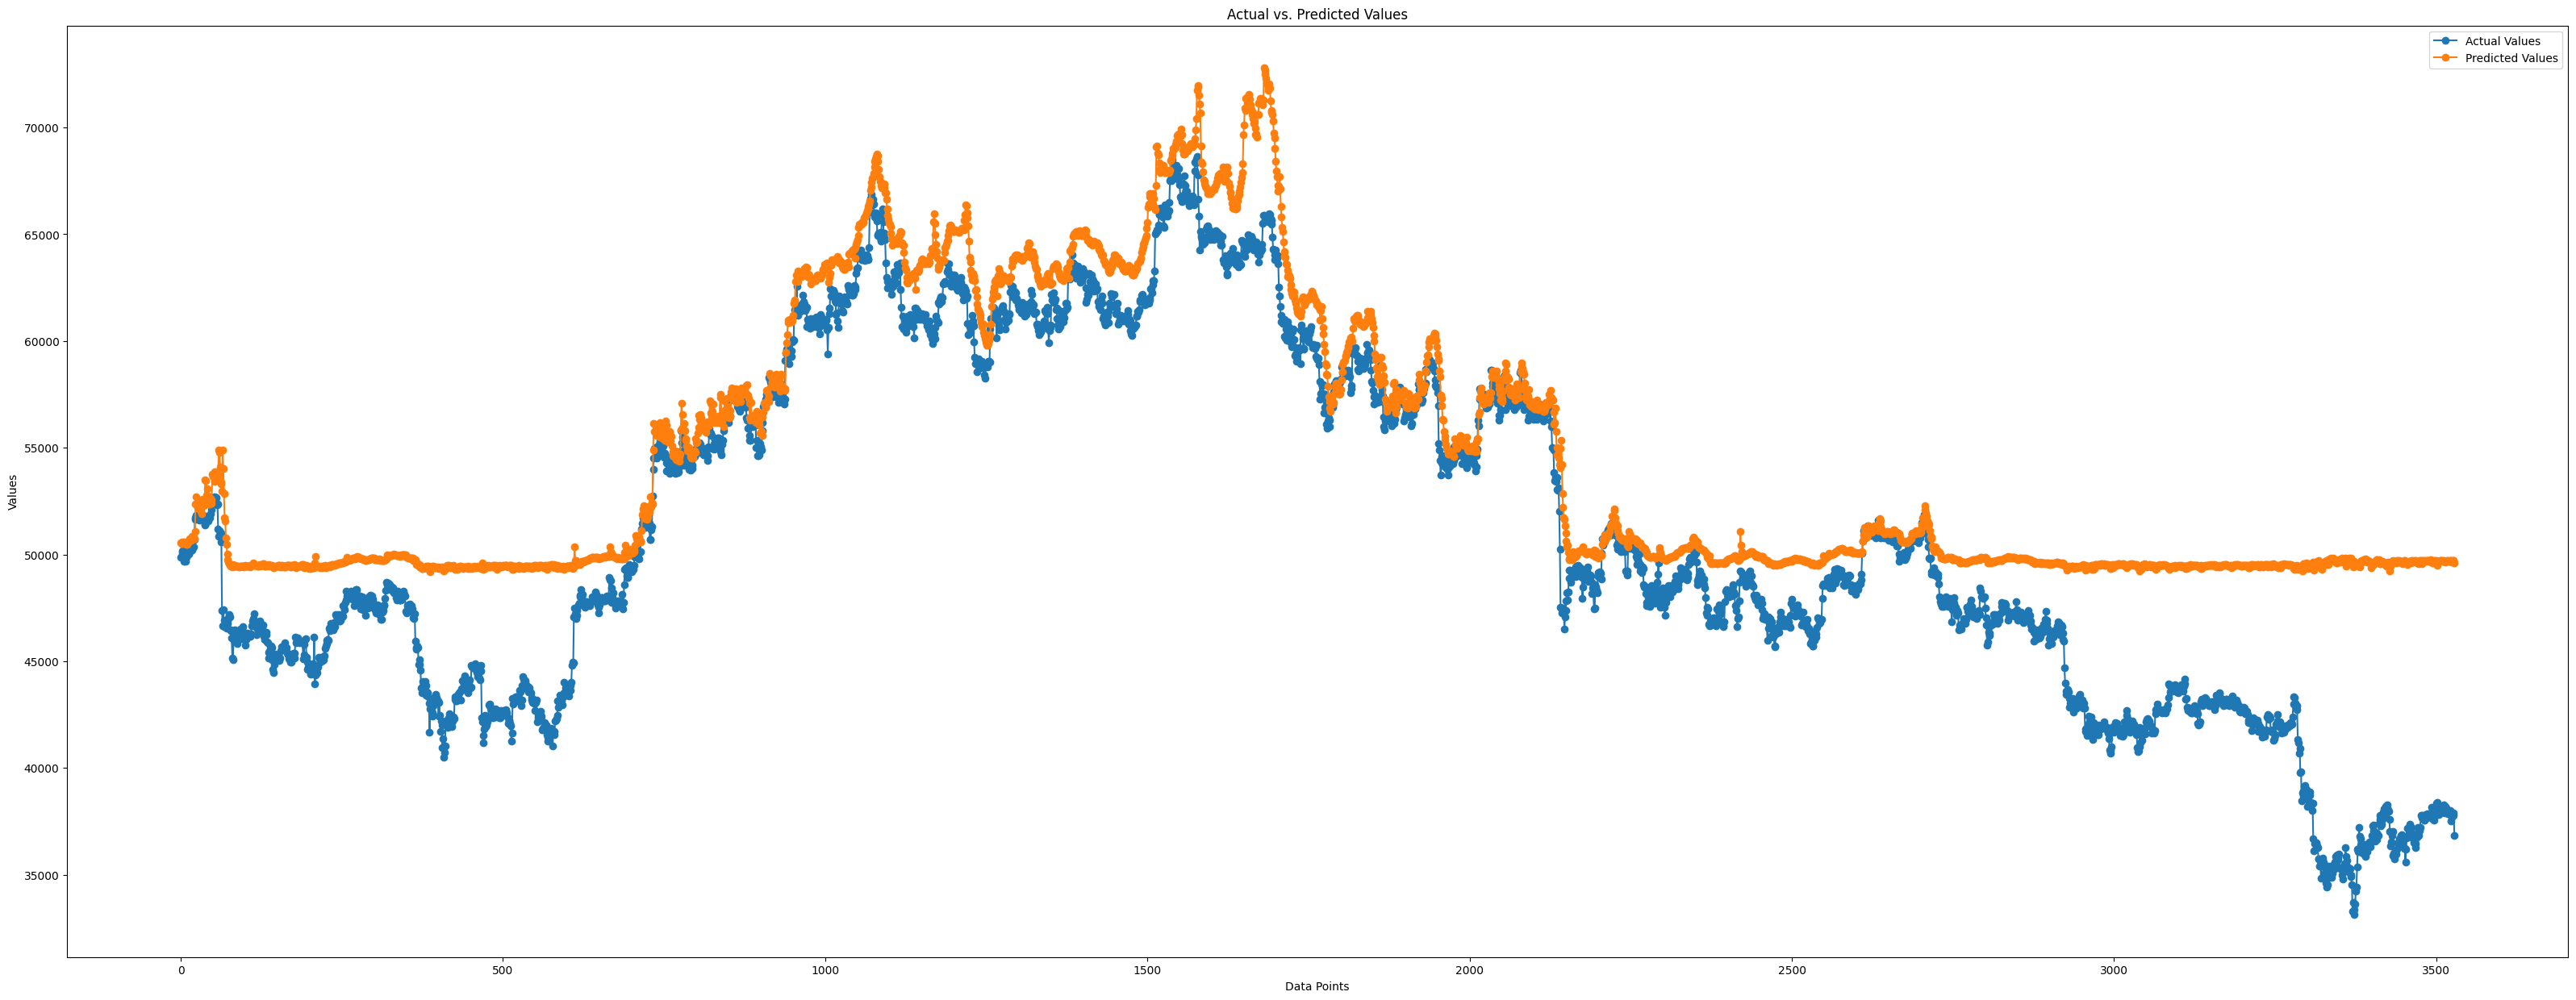

984/984 [==============================] - 4s 4ms/step
BACKTESTING RMSE: 2664.67
Testing RMSE: 4851.21
Initial Capital : 100000 

Returned Capital : 233845.8679256572 

Total Gross Profit : 156621.19387807095 

Total Net Profit : 156386.26208725385 

Total Gross Loss (Predicted): -22775.325952413754 

Total Closed Trades (Predicted): 26 

Win Rate (%)(Predicted): 92.3076923076923 

Loss Rate (%)(Predicted): 7.6923076923076925 

Max Drawdown (Predicted): -17485.98591386623 

Max Drawdown (Predicted) as a percentage: -10.16% 

Average Winning Trade (in USDT)(Predicted): 6525.883078252956 

Average Losing Trade (in USDT)(Predicted): -11387.662976206877 

Buy and Hold Return of BTC (%)(Predicted): -1.8404491245746613 

Average Annual Return of BTC (Predicted): -4.51%
Largest Losing Trade (in USDT)(Predicted): -17485.98591386623 

Largest Winning Trade (in USDT)(Predicted): 14791.349877269968 

Sharpe Ratio (Predicted): 0.8444958716104244 

Sortino Ratio (Predicted): 1.0734531537961867 

Av

In [21]:
testing(test_df)

testX shape == (7969, 24, 9).
testY shape == (7969, 1).
250/250 [==============================] - 1s 4ms/step
Predictions shape: (7969, 1)


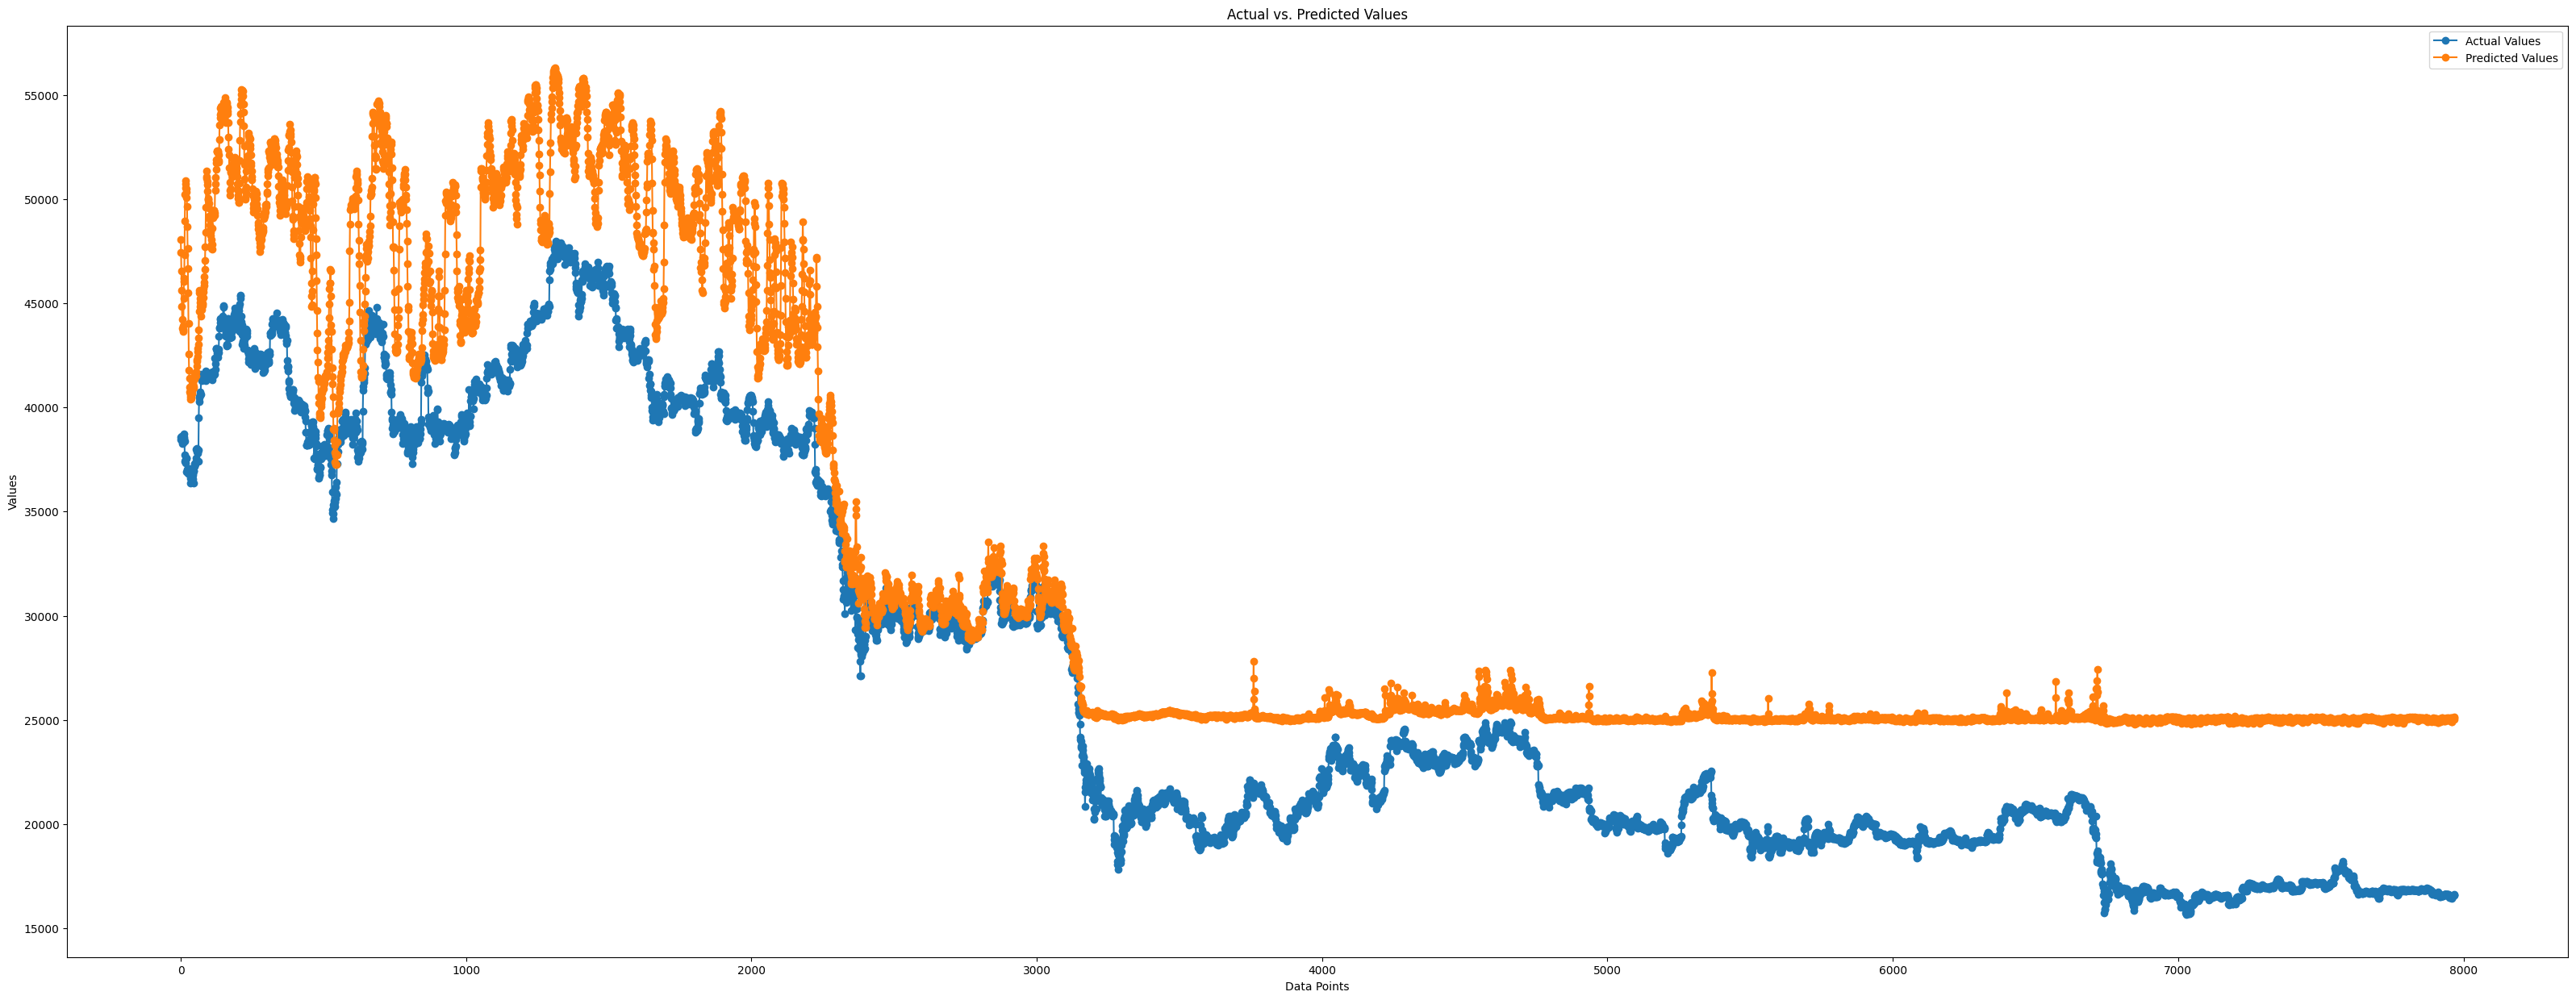

984/984 [==============================] - 4s 4ms/step
BACKTESTING RMSE: 3182.95
Testing RMSE: 6177.77
Initial Capital : 100000 

Returned Capital : 94488.08842765611 

Total Gross Profit : 2104.163241299597 

Total Net Profit : 2101.0069964376476 

Total Gross Loss (Predicted): -7616.074813643485 

Total Closed Trades (Predicted): 6 

Win Rate (%)(Predicted): 50.0 

Loss Rate (%)(Predicted): 50.0 

Max Drawdown (Predicted): -5618.954620031975 

Max Drawdown (Predicted) as a percentage: -5.59% 

Average Winning Trade (in USDT)(Predicted): 701.3877470998656 

Average Losing Trade (in USDT)(Predicted): -2538.6916045478283 

Buy and Hold Return of BTC (%)(Predicted): -47.769567370414734 

Average Annual Return of BTC (Predicted): -51.03%
Largest Losing Trade (in USDT)(Predicted): -5618.954620031975 

Largest Winning Trade (in USDT)(Predicted): 1291.31974394212 

Sharpe Ratio (Predicted): -0.4053009580228215 

Sortino Ratio (Predicted): -0.41677802048031803 

Average Holding Duration per T

In [22]:
testing(out_of_sample_1_df)

testX shape == (5053, 24, 9).
testY shape == (5053, 1).
158/158 [==============================] - 1s 4ms/step
Predictions shape: (5053, 1)


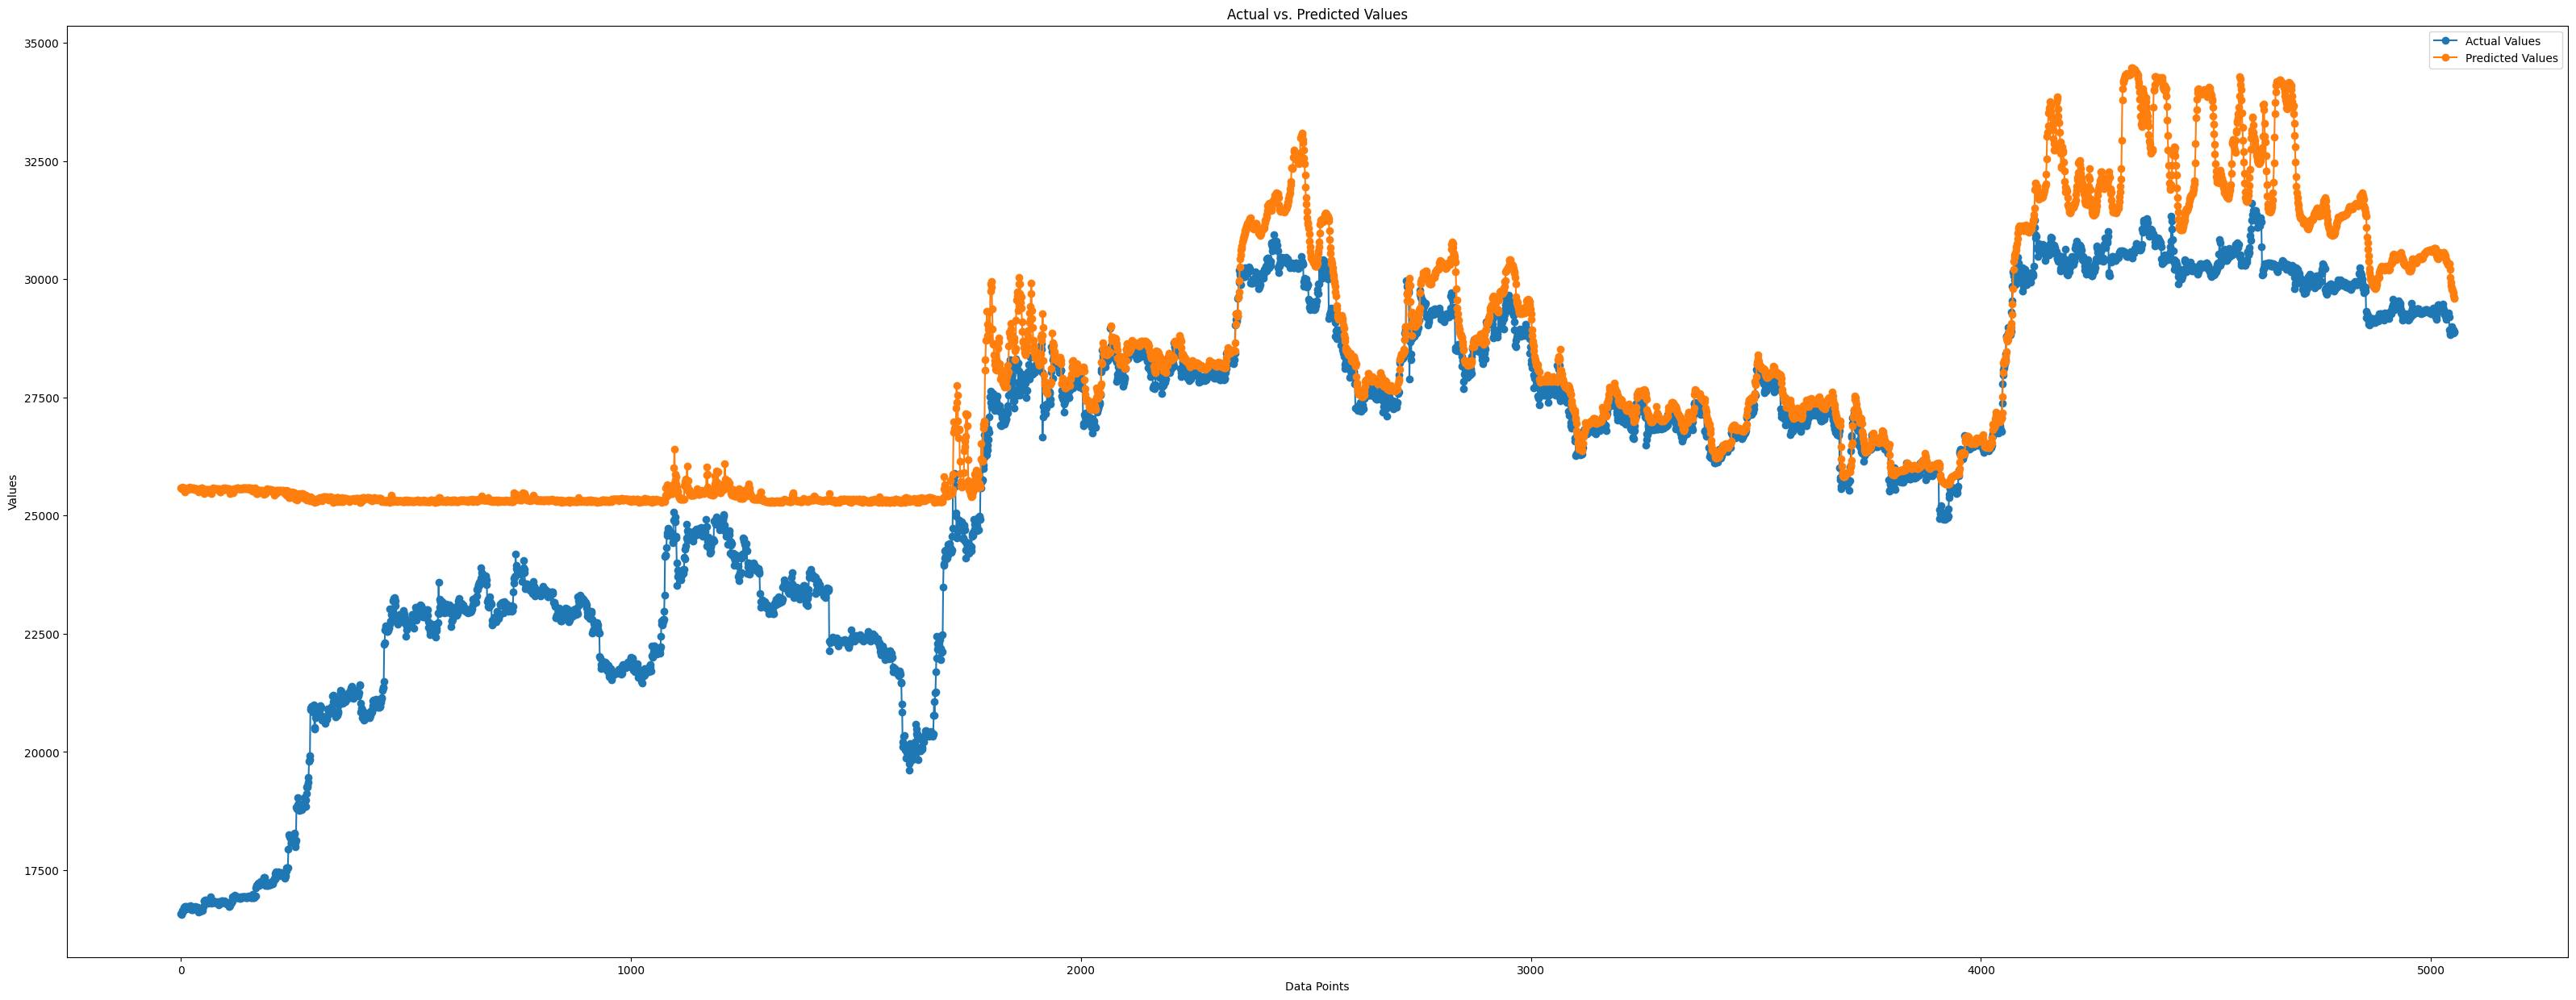

984/984 [==============================] - 4s 4ms/step
BACKTESTING RMSE: 1200.89
Testing RMSE: 2704.53
Initial Capital : 100000 

Returned Capital : 286967.52014417003 

Total Gross Profit : 202657.3242111444 

Total Net Profit : 202353.33822482772 

Total Gross Loss (Predicted): -15689.804066974379 

Total Closed Trades (Predicted): 40 

Win Rate (%)(Predicted): 90.0 

Loss Rate (%)(Predicted): 10.0 

Max Drawdown (Predicted): -9408.15079274858 

Max Drawdown (Predicted) as a percentage: -6.34% 

Average Winning Trade (in USDT)(Predicted): 5629.3701169762335 

Average Losing Trade (in USDT)(Predicted): -3922.4510167435947 

Buy and Hold Return of BTC (%)(Predicted): 15.656186640262604 

Average Annual Return of BTC (Predicted): 28.68%
Largest Losing Trade (in USDT)(Predicted): -9408.15079274858 

Largest Winning Trade (in USDT)(Predicted): 25036.264300417504 

Sharpe Ratio (Predicted): 0.8360154050821368 

Sortino Ratio (Predicted): 1.0582473556266432 

Average Holding Duration per Tr

In [23]:
testing(out_of_sample_2_df)